In [ ]:
#!pip install primefac ## doing number theory with python is goofy, but w/e
#!pip install pyarrow   ## for serialization of files in parquet format

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [3]:

from sklearn.neighbors import KernelDensity

In [4]:
plt.style.use('dark_background')

In [5]:
import primefac

In [94]:
list(primefac.primefac(270))

[2, 3, 3, 3, 5]

In [95]:
np.log(2*3*3*3)

np.float64(3.9889840465642745)

In [7]:
primefac.isprime(68)

False

In [8]:
primefac.isprime(47)

True

I started off trying to show something related to arcsines, but this is kind of cool on its own. there are interesting patterns in the ratio of a number to its max prime factor.

In [ ]:
max_prime_factors = {}
REGEN = False

file_counter = 0
last_number = (file_counter * (10**6))
if last_number < 4:
    last_number = 4

END_AT = 10**8

if REGEN:
    for x in range(last_number, END_AT+1):
        if not primefac.isprime(x):
            facs = list(primefac.primefac(x))

            max_prime_factor = max(facs)
            # no need to calculate this as we go along
            #np.log(x/max_prime_factor)

            max_prime_factors[x] = max_prime_factor
            
        if (x % 10**6) == 0:
            # parquet handles big data files well
            ratios_df = pd.DataFrame(max_prime_factors.items())
            ratios_df.to_parquet(f"max_prime_factors.df.parquet")

            with open("last_number", "w") as f:
                f.write(str(x))
                
            file_counter += 1


In [11]:
all_data = pd.read_parquet("max_prime_factors.df.parquet")
all_data = all_data.rename({0: 'number', 1:'max_prime_factor'}, axis=1)

In [12]:
all_data

,number,max_prime_factor
0,4,2
1,6,3
2,8,2
3,9,3
4,10,5
...,...,...
66826621,70999995,430303
66826622,70999996,17749999
66826623,70999998,1061
66826624,70999999,10142857


there is some research on the distribution of the ratio of the log of numbers vs. their max prime factors. but I found the difference is more interesting.

In [87]:
all_data['log_diff'] = np.log(all_data.number) - np.log(all_data.max_prime_factor)

all_data['log_log_diff'] = np.log(all_data.log_diff)

In [18]:
all_data['log_ratio'] = np.log(all_data.number) / np.log(all_data.max_prime_factor)
all_data['log_log_ratio'] = np.log(all_data.log_ratio)

In [104]:
all_data['ratio'] = all_data.number / all_data.max_prime_factor

In [105]:
all_data[:1000].ratio.max()

np.float64(512.0)

In [107]:
len(all_data[all_data.number < 1000].ratio.unique())

86

In [111]:
test_ratios = all_data[all_data.number < 1000].ratio.copy()

test_logs = np.log(test_ratios)

len(test_logs.unique())


86

this is a problem. there are only 86 unique ratios but 180 different `log_diff` values in the same range.

In [103]:
len(all_data[all_data.number < 1000].log_diff.unique())

180

In [112]:
test_log_diffs = all_data[all_data.number < 1000].log_diff.copy()

here's the problem:

In [116]:
test_log_diffs[test_log_diffs < 1].unique()

array([0.69314718, 0.69314718, 0.69314718, 0.69314718, 0.69314718,
       0.69314718, 0.69314718])

so, the problem was I was subtracting two logs instead of dividing them first and taking the log of that. mathematically, that's the same thing, but I'm introducing error.

In [117]:
all_data['log_diff2'] = np.log(all_data.number / all_data.max_prime_factor)


In [118]:
test_log2 = all_data[all_data.number < 1000].log_diff2.copy()

In [119]:
test_log2[test_log2<1].unique()

array([0.69314718])

so, I'll do a little switcheroo. from here, `log_diff` should be correct.

In [120]:
all_data['log_diff'] = all_data['log_diff2']


In [121]:
all_data.log_diff.describe()

count    6.682663e+07
mean     6.451414e+00
std      3.167249e+00
min      6.931472e-01
25%      3.891820e+00
50%      6.647688e+00
75%      8.918784e+00
max      1.732868e+01
Name: log_diff, dtype: float64

In [88]:
all_data.log_log_diff.describe()

count    6.682663e+07
mean     1.682204e+00
std      6.921315e-01
min     -3.665129e-01
25%      1.358877e+00
50%      1.894269e+00
75%      2.188160e+00
max      2.852363e+00
Name: log_log_diff, dtype: float64

<Axes: >

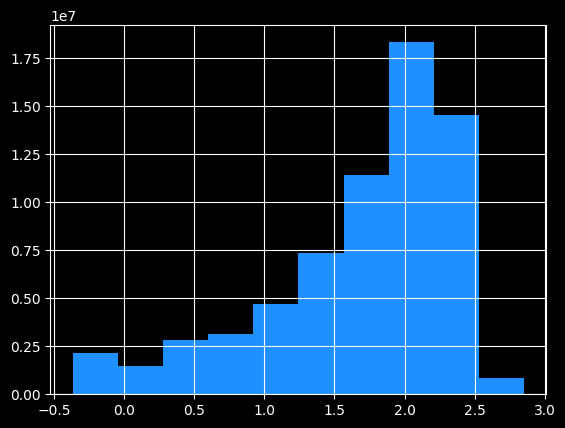

In [89]:
all_data.log_log_diff.hist(color='dodgerblue')

In [90]:
all_data.log_log_diff.min()

np.float64(-0.3665129205816668)

In [15]:
all_data.idxmax()

number              66826625
max_prime_factor    66826535
log_diff            63151053
dtype: int64

In [16]:
all_data.loc[all_data.max_prime_factor.idxmax()]

number              7.099991e+07
max_prime_factor    3.549995e+07
log_diff            6.931472e-01
Name: 66826535, dtype: float64

In [19]:
all_data.loc[all_data.log_ratio.idxmax()]

number              6.710886e+07
max_prime_factor    2.000000e+00
log_diff            1.732868e+01
log_ratio           2.600000e+01
log_log_ratio       3.258097e+00
Name: 63151053, dtype: float64

the range of `log_diff` should be between .693 (log 2) and the log of the biggest number in the dataframe

In [ ]:
np.log(all_data.iloc[-1].number)

np.float64(18.078190435005588)

In [55]:
all_data.sample(100000).log_diff.value_counts()

log_diff
0.693147     1367
1.386294     1325
0.693147     1259
1.098612     1221
1.609438      822
             ... 
10.745723       1
9.559799        1
8.141772        1
10.970403       1
11.086824       1
Name: count, Length: 36378, dtype: int64

<Axes: >

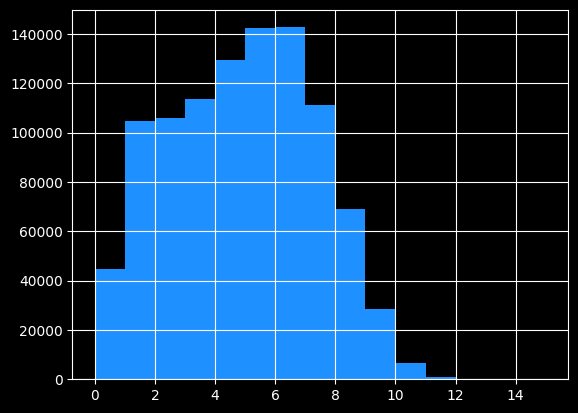

In [122]:
all_data[:1000000].log_diff.hist(bins=range(0,16), color="dodgerblue")

In [21]:
all_data.log_log_ratio.min()

np.float64(0.039096012826222167)

In [40]:
all_data.log_log_ratio.max()

np.float64(3.258096538021482)

In [22]:
all_data.log_diff.max()

np.float64(17.328679513998633)

(array([5.03226e+05, 4.12851e+05, 7.93240e+04, 4.36600e+03, 2.16000e+02,
        1.70000e+01]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ]),
 <BarContainer object of 6 artists>)

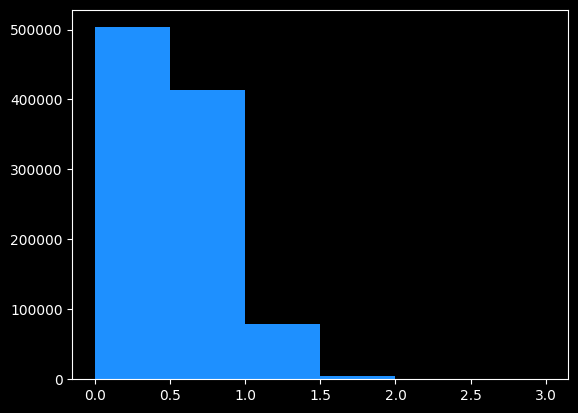

In [56]:
plt.hist(all_data[:1000000].log_log_ratio, bins=[0,.5,1,1.5,2,2.5,3], color='dodgerblue')

In [24]:
list(primefac.primefac(60595354))

[2, 101, 299977]

In [ ]:
len(all_data[1:100])

99

In [ ]:
all_data[1:100]

,number,max_prime_factor,log_ratio,log_diff,log_log_ratio
1,6,3,1.630930,0.693147,0.489150
2,8,2,3.000000,1.386294,1.098612
3,9,3,2.000000,1.098612,0.693147
4,10,5,1.430677,0.693147,0.358147
5,12,3,2.261860,1.386294,0.816187
...,...,...,...,...,...
95,128,2,7.000000,4.158883,1.945910
96,129,43,1.292091,1.098612,0.256262
97,130,13,1.897712,2.302585,0.640649
98,132,11,2.036287,2.484907,0.711128


In [ ]:
list(primefac.primefac(43046721))

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [ ]:
list(primefac.primefac(45378900))

[2, 2, 3, 3, 3, 5, 5, 7, 7, 7, 7, 7]

<Axes: >

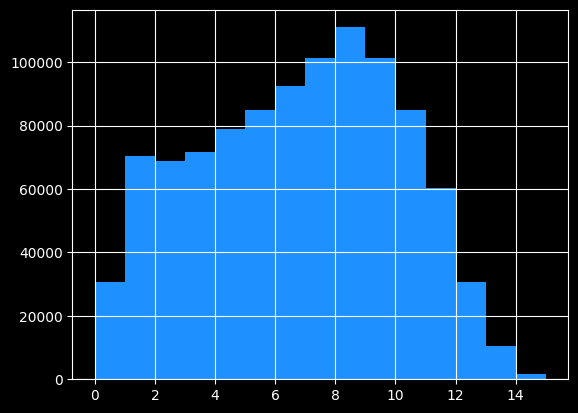

In [ ]:
all_data[58000000:59000000].log_diff.hist(bins=range(0,16), color="dodgerblue")

In [85]:
np.exp(16)

np.float64(8886110.520507872)

TODO: problems --

these scales need to be consistent (or you need to show them all on the same scale)

this has an interesting self-similar nature -- let's use kernel density estimation to get some curves.

note: there is a fair amount of variance at the lower values in some regions of the graph

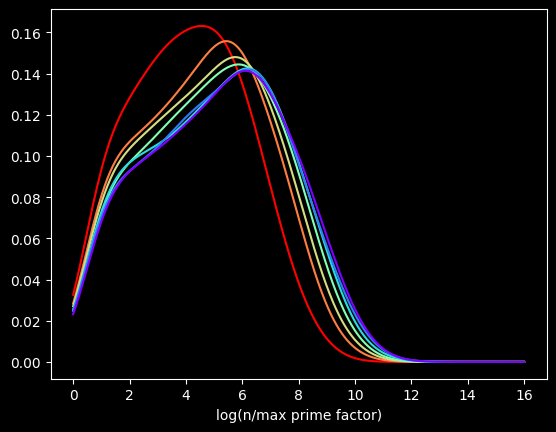

In [151]:
def plot_curve(batch_size=10000000, sample_size=1000000,
               max_batches=7, max_xrange=16, kernel_name="gaussian"):

    xrange = np.linspace(0,max_xrange,500)

    colors = plt.cm.rainbow(1-np.linspace(0,1,max_batches))

    fits = {}

    for x in range(0, max_batches):
        lower_range = x * batch_size
        upper_range = (x+1) * batch_size

        batch_data = all_data[lower_range:upper_range].log_diff.sample(sample_size).to_numpy().reshape(-1, 1)

        kernel = KernelDensity(kernel=kernel_name, bandwidth=0.75).fit(batch_data)

        #kernel = scipy.stats.gaussian_kde(batch_data.log_diff)
        #kernel_fit = kernel.pdf(xrange)

        # scikit version returns the log of the density, for some reason.
        kernel_fit = np.exp(kernel.score_samples(xrange[:, np.newaxis]))

        fits[x] = kernel_fit

        plt.plot(xrange, kernel_fit, color=colors[x])

    _ = plt.xlabel("log(n/max prime factor)")
    return fits

fits1 = plot_curve(100000, 10000)

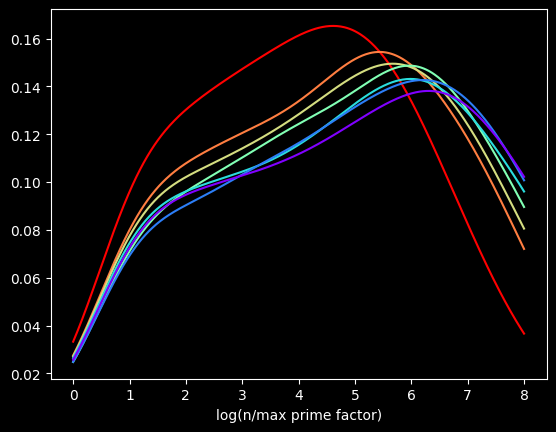

In [60]:
fits_zoom = plot_curve(100000, 10000, max_xrange=8)

KDE is letting us down here a bit. the minimum value possible is log(2) == .693, and yet the curve starts at 0.

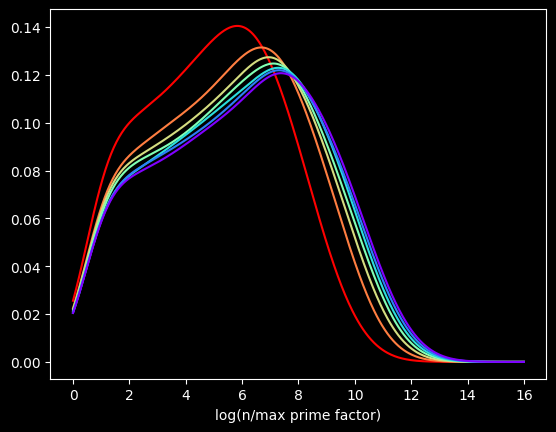

In [48]:

fits2 = plot_curve(1000000, 100000)

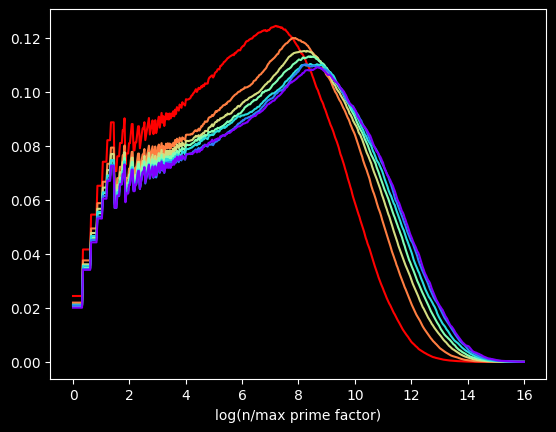

In [160]:
fits_tophat = plot_curve(10000000, 100000, kernel_name="tophat")

In [123]:
np.log(1000)

np.float64(6.907755278982137)

In [54]:
fits2[0][0]

np.float64(0.025571299453304164)

In [53]:
fits2[0].max()

np.float64(0.14042678878864026)

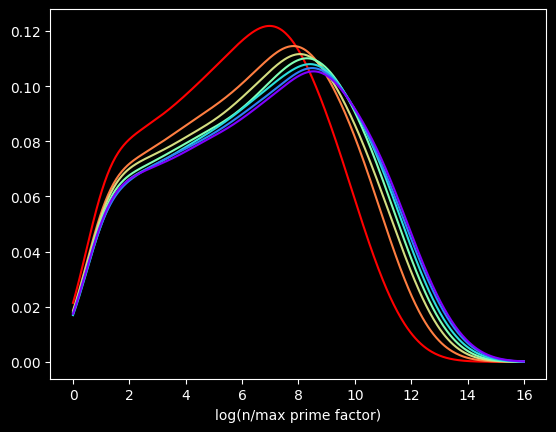

In [45]:

fits3 = plot_curve(10000000, 100000)

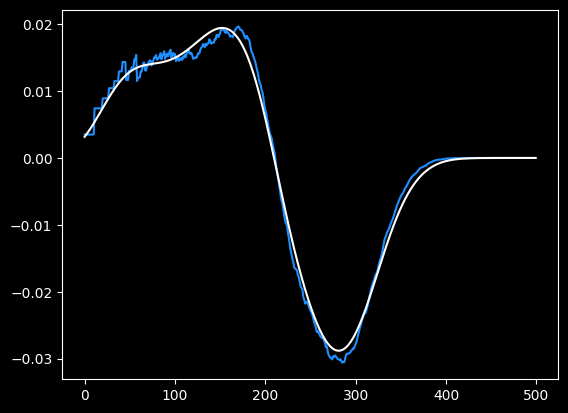

In [154]:
plt.plot(fits_tophat[0] - fits_tophat[1], color='dodgerblue')
plt.plot(fits2[0] - fits2[1], color='white')
#plt.plot(fits3[0] - fits3[1])

In [156]:
np.log(19)

np.float64(2.9444389791664403)

In [ ]:
all_data[all_data.log_diff < .7]

,number,max_prime_factor,log_ratio,log_diff,log_log_ratio
0,4,2,2.000000,0.693147,0.693147
1,6,3,1.630930,0.693147,0.489150
4,10,5,1.430677,0.693147,0.358147
6,14,7,1.356207,0.693147,0.304692
12,22,11,1.289065,0.693147,0.253917
...,...,...,...,...,...
66826455,70999822,35499911,1.039870,0.693147,0.039096
66826459,70999826,35499913,1.039870,0.693147,0.039096
66826512,70999882,35499941,1.039870,0.693147,0.039096
66826516,70999886,35499943,1.039870,0.693147,0.039096


I will need to pick an arbitrary cutoff for probability to get the scaling factor.

todo: look at frequency of a particular value across ranges

In [61]:
log_diff_six = all_data[(all_data.log_diff > 6) & (all_data.log_diff < 6.9)]

In [75]:
len(log_diff_six)

6041807

In [73]:
log_diff_six.log_diff.value_counts()

log_diff
6.030685    8651
6.021023    8628
6.035481    8591
6.008813    8577
6.001415    8525
            ... 
6.899723       1
6.815640       1
6.614726       1
6.710523       1
6.695799       1
Name: count, Length: 2629, dtype: int64

In [77]:
all_data[(all_data.log_diff > 6.030684) & (all_data.log_diff < 6.030686)]

,number,max_prime_factor,log_diff,log_ratio,log_log_ratio
4693,5408,13,6.030685,3.351191,1.209316
6162,7072,17,6.030685,3.128567,1.140575
6904,7904,19,6.030685,3.048161,1.114538
8383,9568,23,6.030685,2.923360,1.072734
10618,12064,29,6.030685,2.790958,1.026385
...,...,...,...,...,...
66808503,70980832,170627,6.030685,1.500587,0.405856
66810870,70983328,170633,6.030685,1.500585,0.405855
66814014,70986656,170641,6.030685,1.500583,0.405854
66816362,70989152,170647,6.030685,1.500582,0.405853


In [84]:
5408/ 13

416.0

In [83]:
7072/17

416.0

In [78]:
all_data.log_diff

0            0.693147
1            0.693147
2            1.386294
3            1.098612
4            0.693147
              ...    
66826621     5.105945
66826622     1.386294
66826623    11.111223
66826624     1.945910
66826625    13.815511
Name: log_diff, Length: 66826626, dtype: float64

<Axes: >

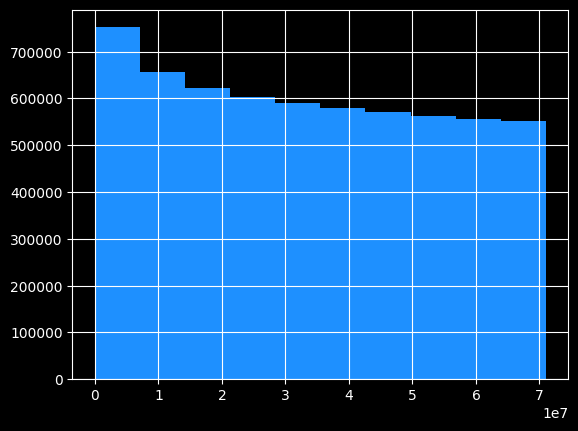

In [63]:
log_diff_six.number.hist(color='dodgerblue')

In [126]:
all_data[all_data.log_diff < 2].log_diff.unique()

array([0.69314718, 1.38629436, 1.09861229, 1.79175947, 1.60943791,
       1.94591015])

In [132]:
all_data[(all_data.log_diff > 1) & (all_data.log_diff <3)].ratio.unique()

array([ 4.,  3.,  8.,  6.,  5.,  9., 16., 12.,  7., 10., 18., 15., 14.,
       20., 11., 13., 17., 19.])

In [149]:
np.exp(8)

np.float64(2980.9579870417283)

In [137]:
rvc = all_data.ratio.value_counts()

In [139]:
rvc[2.0] /rvc[3.0]

np.float64(1.4624888658830488)

In [141]:
rvc[3.0] / rvc[4.0]

np.float64(1.3090898690509716)

In [142]:
rvc[4.0] / rvc[5.0]

np.float64(1.2321959333803951)

In [143]:
rvc[5.0] / rvc[6.0]

np.float64(1.1856067326457724)

In [130]:
all_data[all_data.log_diff < 4].ratio.unique()

array([ 2.,  4.,  3.,  8.,  6.,  5.,  9., 16., 12.,  7., 10., 18., 32.,
       24., 15., 27., 14., 20., 36., 11., 25., 48., 21., 30., 54., 13.,
       28., 40., 45., 22., 35., 50., 17., 42., 26., 49., 19., 33., 44.,
       39., 23., 34., 52., 38., 29., 51., 31., 46., 37., 41., 43., 47.,
       53.])

In [158]:
rvc

ratio
2.0          2175518
3.0          1487545
4.0          1136320
5.0           922191
6.0           777822
              ...   
5460000.0          1
1059404.0          1
210625.0           1
193409.0           1
628167.0           1
Name: count, Length: 178848, dtype: int64